https://github.com/timesler/facenet-pytorch/blob/master/examples/finetune.ipynb 

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import numpy as np
import os

from sklearn.metrics import accuracy_score,f1_score,precision_score
from torchsummaryX import summary
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import wandb

wandb.init(project="milestone2_resnet18")

/data_seoul/dain5832/anaconda3/envs/cmu-deeplearning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dain5832. Use `wandb login --relogin` to force relogin


In [2]:
#data_dir = './data/lfw'
data_dir = '/data_seoul/dain5832/cmu/summer/celebA/celeba'

batch_size = 128
epochs = 30
workers = 0 if os.name == 'nt' else 8

wandb.config.batch_size = batch_size
wandb.config.epochs = epochs

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## InceptionResnetV1

In [17]:
class InceptionResnetV1_multilabel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        #self.resnet = InceptionResnetV1(
        #    classify=True,
        #    pretrained='vggface2',
        #    num_classes=n_classes
        #)
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, n_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize the model
model = InceptionResnetV1_multilabel(40).to(device)

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

wandb.config.lr = 0.001
wandb.config.optim = 'Adam'

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
#dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
dataset = datasets.CelebA(root='/data_seoul/dain5832/cmu/summer/celebA', split='valid', target_type='attr', transform=trans)

img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

In [19]:
for (x,y) in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 3, 218, 178]) torch.Size([128, 40])


In [20]:
for (x,y) in val_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 3, 218, 178]) torch.Size([128, 40])


In [21]:
loss_fn = torch.nn.BCEWithLogitsLoss()
metrics = {
    
}

In [22]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
model.eval()
pass_epoch(
    model, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

epochs = 10
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    model.train()
    pass_epoch(
        model, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    model.eval()
    pass_epoch(
        model, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    torch.save(model.state_dict(), 'model_{}.pth'.format(epoch))

writer.close()

In [23]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
model.eval()
pass_epoch(
    model, loss_fn, val_loader,
    show_running=True, device=device,
    writer=writer
)

epochs = 10
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    model.train()
    pass_epoch(
        model, loss_fn, train_loader, optimizer, scheduler,
        show_running=True, device=device,
        writer=writer
    )

    model.eval()
    pass_epoch(
        model, loss_fn, val_loader,
        show_running=True, device=device,
        writer=writer
    )
    torch.save(model.state_dict(), 'model_{}.pth'.format(epoch))

writer.close()



Initial
----------
Valid |    32/32   | loss:    0.7120 |    
f1score: 0.301
precision: 0.224

Epoch 1/10
----------
Train |   125/125  | loss:    0.2448 |    
f1score: 0.715
precision: 0.82
Valid |    32/32   | loss:    0.2450 |    
f1score: 0.725
precision: 0.787

Epoch 2/10
----------
Train |   125/125  | loss:    0.1975 |    
f1score: 0.776
precision: 0.848
Valid |    32/32   | loss:    0.2273 |    
f1score: 0.756
precision: 0.788

Epoch 3/10
----------
Train |   125/125  | loss:    0.1766 |    
f1score: 0.802
precision: 0.862
Valid |    32/32   | loss:    0.2147 |    
f1score: 0.769
precision: 0.806

Epoch 4/10
----------
Train |   125/125  | loss:    0.1571 |    
f1score: 0.827
precision: 0.876
Valid |    32/32   | loss:    0.2373 |    
f1score: 0.757
precision: 0.796

Epoch 5/10
----------
Train |   125/125  | loss:    0.1340 |    
f1score: 0.857
precision: 0.898
Valid |    32/32   | loss:    0.2426 |    
f1score: 0.74
precision: 0.845

Epoch 6/10
----------
Train |   125/125 

## Test

In [11]:

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
#dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
dataset = datasets.CelebA(root='/data_seoul/dain5832/cmu/summer/celebA', split='test', target_type='attr', transform=trans)

img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)

test_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(img_inds)
)

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

df_attr = pd.read_csv('/data_seoul/dain5832/cmu/summer/celebA/celeba/list_attr_celeba.txt', delim_whitespace=True, header=1)
df_attr.replace(-1,0,inplace=True)
df_attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


40


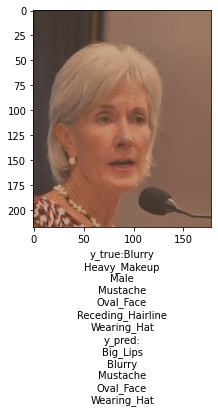

In [13]:
for (images, attr) in test_loader:
    idx= 0
    y_pred = model(images.to(device))
    prediction=torch.round(torch.sigmoid(y_pred)).detach().cpu()

    images=images.cpu().numpy().transpose((0,2,3,1))
    plt.imshow(images[idx]*[0.2644, 0.2436, 0.2397]+[0.5063, 0.4258, 0.3832])
    labels=df_attr.columns.tolist()
    labels=labels[1:]
    att=attr[idx].numpy()
    prediction = prediction[idx].numpy().astype(int)
    print(len(prediction))
    preds = ""
    for label,a in list(zip(labels,prediction)):
        if a== 1:
            preds+= "\n"+label
    labels="\n".join([label for label,a in list(zip(labels,att)) if a==1])
    #preds = "\n".join([label for label,a in list(zip(labels,prediction)) if a==1])
    plt.xlabel("y_true:"+labels+"\n"+"y_pred:"+preds)
    plt.show()
    break